In [34]:
#Cada columna representa un regundo de actividad del paciente.
#Cada fila representa un paciente diferente.
#La columna y es la categoria a la cual pertenece el paciente
#    5 - eyes open, means when they were recording the EEG signal of the brain the patient had their eyes open 
#    4 - eyes closed, means when they were recording the EEG signal the patient had their eyes closed 
#    3 - Yes they identify where the region of the tumor was in the brain and recording the EEG activity from the healthy brain area 
#    2 - They recorder the EEG from the area where the tumor was located 
#    1 - Recording of seizure activity 
#De la categoria de 2-5 son pacientes que no sufren de epilepsia, y la 1 si. 

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score
import itertools
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [36]:
data = pd.read_csv("Data/data.csv")
del data["Unnamed: 0"]#borrando primera columna, correspondiente a la identificacion del paciente

In [37]:
np.sum(np.sum(data.isna())) # checking for nan values

0

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #if normalize:
    #    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #    print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [39]:
X = data
y = data["y"]

In [40]:
def logisticRegression(X, y):
    Xtr, Xts, ytr, yts = train_test_split(X,y,test_size=0.5)
    clf = LogisticRegression(solver='lbfgs', multi_class='ovr')
    clf.fit(Xtr, ytr)
    predicts = clf.predict(Xts)
    acc = clf.score(Xts, yts)
    print "Logistic regression reports:\n", classification_report(yts, predicts)
    print "Logistic regression accuracy:", acc
    return confusion_matrix(yts, predicts)

Logistic regression reports:
             precision    recall  f1-score   support

          1       0.70      0.33      0.45      1154
          2       0.10      0.02      0.04      1155
          3       0.12      0.02      0.04      1142
          4       0.20      0.16      0.18      1176
          5       0.27      0.91      0.42      1123

avg / total       0.28      0.29      0.23      5750

Logistic regression accuracy: 0.2883478260869565


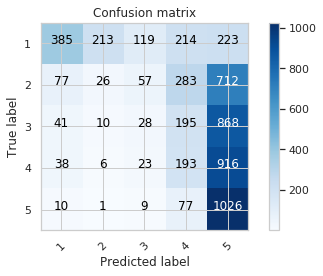

In [41]:
conf_matrix = logisticRegression(X, y)
plt.figure()
plot_confusion_matrix(conf_matrix, classes=['1', '2', '3', '4', '5'], title='Confusion matrix')
plt.show()

In [42]:
def svm(X, y):
    print "calculating..."
    Xtr, Xts, ytr, yts = train_test_split(X,y,test_size=0.3)
    clf = SVC(kernel="poly", degree=3, gamma = 150)
    clf.fit(Xtr, ytr)
    predicts = clf.predict(Xts)
    acc = clf.score(Xts, yts)
    print "SVM reports:\n", classification_report(yts, predicts)
    print "SVM accuracy:", acc
    return confusion_matrix(yts, predicts)

calculating...
SVM reports:
             precision    recall  f1-score   support

          1       0.93      0.46      0.61       677
          2       0.32      0.48      0.38       665
          3       0.33      0.54      0.41       710
          4       0.44      0.27      0.33       703
          5       0.27      0.21      0.24       695

avg / total       0.46      0.39      0.40      3450

SVM accuracy: 0.39072463768115945


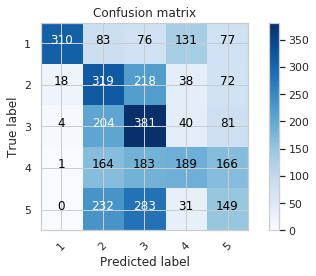

In [43]:
conf_matrix = svm(X, y)
plt.figure()
plot_confusion_matrix(conf_matrix, classes=['1', '2', '3', '4', '5'], title='Confusion matrix')
plt.show()

In [44]:
def randomForest(X, y):
    print "calculating..."
    Xtr, Xts, ytr, yts = train_test_split(X,y,test_size=0.3)
    clf = RandomForestClassifier(max_depth=25)
    clf.fit(Xtr, ytr)
    predicts = clf.predict(Xts)
    acc = clf.score(Xts, yts)
    print "Random Forest reports:\n", classification_report(yts, predicts)
    print "Random Forest accuracy:", acc
    return confusion_matrix(yts, predicts)

calculating...
Random Forest reports:
             precision    recall  f1-score   support

          1       0.94      0.96      0.95       675
          2       0.90      0.90      0.90       711
          3       0.90      0.88      0.89       709
          4       0.94      0.94      0.94       648
          5       1.00      1.00      1.00       707

avg / total       0.93      0.93      0.93      3450

Random Forest accuracy: 0.9342028985507247


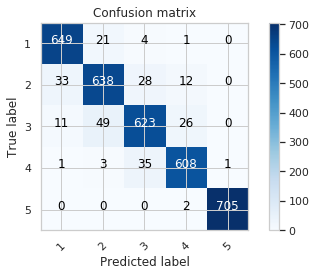

In [45]:
conf_matrix = randomForest(X, y)
plt.figure()
plot_confusion_matrix(conf_matrix, classes=['1', '2', '3', '4', '5'], title='Confusion matrix')
plt.show()

In [46]:
def decisionTree(X, y):
    print "calculating..."
    Xtr, Xts, ytr, yts = train_test_split(X,y,test_size=0.3)
    clf = DecisionTreeClassifier(max_depth=4);
    clf.fit(Xtr, ytr)
    predicts = clf.predict(Xts)
    acc = clf.score(Xts, yts)
    print "Decision tree reports:\n", classification_report(yts, predicts)
    print "Decision tree accuracy:", acc
    return confusion_matrix(yts, predicts)

calculating...
Decision tree reports:
             precision    recall  f1-score   support

          1       1.00      1.00      1.00       704
          2       1.00      1.00      1.00       684
          3       1.00      1.00      1.00       705
          4       1.00      1.00      1.00       681
          5       1.00      1.00      1.00       676

avg / total       1.00      1.00      1.00      3450

Decision tree accuracy: 1.0


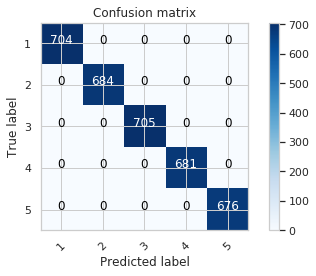

In [47]:
conf_matrix = decisionTree(X, y)
plt.figure()
plot_confusion_matrix(conf_matrix, classes=['1', '2', '3', '4', '5'], title='Confusion matrix')
plt.show()

In [48]:
def knn(X, y):
    print "calculating..."
    Xtr, Xts, ytr, yts = train_test_split(X,y,test_size=0.3)
    clf = KNeighborsClassifier(n_neighbors=7);
    clf.fit(Xtr, ytr)
    predicts = clf.predict(Xts)
    acc = clf.score(Xts, yts)
    print "KNN reports:\n", classification_report(yts, predicts)
    print "KNN accuracy:", acc
    return confusion_matrix(yts, predicts)

calculating...
KNN reports:
             precision    recall  f1-score   support

          1       0.99      0.66      0.79       695
          2       0.34      0.62      0.44       691
          3       0.36      0.63      0.46       738
          4       0.86      0.25      0.38       664
          5       0.26      0.10      0.15       662

avg / total       0.56      0.46      0.45      3450

KNN accuracy: 0.4579710144927536


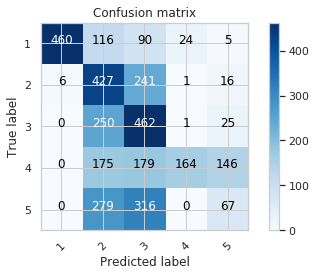

In [49]:
conf_matrix = knn(X, y)
plt.figure()
plot_confusion_matrix(conf_matrix, classes=['1', '2', '3', '4', '5'], title='Confusion matrix')
plt.show()